In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import glob
import time
import random
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, losses, optimizers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from sklearn.metrics import confusion_matrix, classification_report
from keras.preprocessing.image import ImageDataGenerator

In [2]:
gpus = tf.config.list_physical_devices('GPU')
tf.config.set_logical_device_configuration(gpus[0], [tf.config.LogicalDeviceConfiguration(memory_limit=15000)])

### Load data

In [3]:
!gdown --id 1Y1vgzPvMeVcXSxDfOlCVia7wsU7p8M6g -O CIFAR10.tar.gz
!tar xzf CIFAR10.tar.gz

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Y1vgzPvMeVcXSxDfOlCVia7wsU7p8M6g
To: /content/CIFAR10.tar.gz
100% 19.8M/19.8M [00:00<00:00, 264MB/s]


### Plot some samples

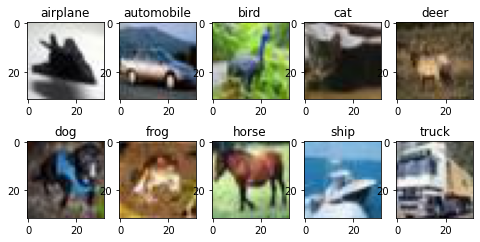

In [4]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

path = '/content/CIFAR10/train/'
figure, axis = plt.subplots(2, 5, figsize=(8,4))

for i in range(10):
  if i < 5:
    axis[0,i].imshow(mpimg.imread(path + class_names[i] + '/0000.jpg'))
    axis[0, i].set_title(class_names[i])
  else:
    axis[1, i-5].imshow(mpimg.imread(path + class_names[i] + '/0000.jpg'))
    axis[1, i-5].set_title(class_names[i])

### Get images matrix

In [5]:
def read_img(folder_path):
  images = []
  for img in glob.glob(folder_path):
    images.append(cv2.imread(img))
  return images

### Get one hot representation of labels

In [6]:
def get_one_hot_labels(input_shape):
  labels = np.zeros(input_shape)
  num_classes = input_shape[1]
  num_samples = input_shape[0]
  samples_per_class = num_samples / num_classes
  j = 0
  for i in range(num_samples):
    if (i < samples_per_class * (j+1)):
      labels[i, j] = 1
    else:
      j += 1
      if j < num_classes:
        labels[i, j] = 1

  return labels

In [7]:
train_path = '/content/CIFAR10/train/'
test_path = '/content/CIFAR10/test/'
X_train = []
X_test = []
for c in class_names[:4]:
  X_train += read_img(train_path+c+'/*.jpg')
  X_test += read_img(test_path+c+'/*.jpg')

X_train = np.array(X_train)
X_test = np.array(X_test)

In [8]:
y_train = get_one_hot_labels((20000, 4))
y_test = get_one_hot_labels((4000, 4))

###Image preprocessing

covert image into greyscale

In [9]:
def rgb2gray(rgb):
    r, g, b = rgb[:, :, :, 0], rgb[:, :, :,1], rgb[:, :, :, 2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

In [11]:
X_train = rgb2gray(X_train)
X_test = rgb2gray(X_test)

normalize data

In [12]:
X_train = (X_train/255)
X_test =(X_test/255)

flat data

In [13]:
X_train = X_train.reshape(-1,1024)
X_test = X_test.reshape(-1,1024)

shuffle data

In [10]:
def shuffle_data(a, b):
    return  shuffle(a, b)

In [14]:
X_train, y_train = shuffle_data(X_train, y_train)
X_test, y_test = shuffle_data(X_test, y_test)

In [15]:
def sigmoid(x):
    return 1 / (1 + (np.exp(-x)))

def sigmoid_deriv(x):
    return sigmoid(x) * (1 - sigmoid(x))

### Initializing weights with normal random values and biases with zeros

In [81]:
w0 = np.random.normal(size=(16,1024))
w1 = np.random.normal(size=(16, 16))
w2 = np.random.normal(size=(4, 16))
b0 = np.zeros((16, 1))
b1 = np.zeros((16, 1))
b2 = np.zeros((4, 1))

W = [w0, w1, w2]
b = [b0, b1, b2]

### Feedforward

In [17]:
def feedforward(W, b, train_X, train_y, num_samples):
    count = 0
    for i in range(num_samples):
      X = train_X[i].reshape(-1, 1)
      a1 = sigmoid(W[0] @ X + b[0])
      a2 = sigmoid(W[1] @ a1 + b[1])
      a3 = sigmoid(W[2] @ a2 + b[2])
      if a3.argmax() == train_y[i].argmax():
        count += 1
    accuracy = count / num_samples
    print('Accutacy: {}%'.format(accuracy*100))

In [23]:
feedforward(W, b, X_train, y_train, 200)

Accutacy: 27.500000000000004%


In [75]:
train_set = list(zip(X_train, y_train))
test_set = list(zip(X_test, y_test))

### Backpropagation

In [36]:
def backpropagation(W, b, train_set, num_epochs, learning_rate, batch_size, num_samples):
  costs = []

  weight1, weight2, weight3 = W[0], W[1], W[2]
  bias1, bias2, bias3 = b[0], b[1], b[2]

  start = time.time()

  for i in range(num_epochs):

    random.shuffle(train_set)
    batches = [train_set[j:j+batch_size] for j in range(0, num_samples, batch_size)]

    for batch in batches:
      grad_w1 = np.zeros((16, 1024))
      grad_w2 = np.zeros((16, 16))
      grad_w3 = np.zeros((4, 16))
      grad_b1 = np.zeros((16, 1))
      grad_b2 = np.zeros((16, 1))
      grad_b3 = np.zeros((4, 1))

      for image, label in batch:
        image = image.reshape(-1,1)
        label = label.reshape(-1,1)

        z1 = weight1 @ image + bias1
        a1 = sigmoid(z1)
        z2 = weight2 @ a1 + bias2
        a2 = sigmoid(z2)
        z3 = weight3 @ a2 + bias3
        a3 = sigmoid(z3)


        for j in range(4):
          for k in range(16):
            grad_w3[j, k] +=  a2[k, 0] * sigmoid_deriv(z3[j, 0])  * (2 * a3[j, 0] - 2 * label[j, 0])

        for j in range(4):
          grad_b3[j, 0] +=  sigmoid_deriv(z3[j, 0]) * (2 * a3[j, 0] - 2 * label[j, 0]) 

        grad_a2 = np.zeros((16,1))
        for k in range(16):
          for j in range(4):
            grad_a2[k, 0] += weight3[j, k] * sigmoid_deriv(z3[j, 0]) * (2 * a3[j,0] - 2 * label[j, 0])
        
        for k in range(16):
          for m in range(16):
            grad_w2[k, m] += a1[m, 0] * grad_a2[k, 0] * sigmoid_deriv(z2[k, 0])
            
            
        for k in range(4):
          grad_b3[k, 0] += grad_a2[k, 0] * sigmoid_deriv(z2[k, 0])


        grad_a1 = np.zeros((16, 1))
        for m in range(16):
          for k in range(16):
            grad_a1[m, 0] += weight2[k, m] * sigmoid_deriv(z2[k, 0]) * grad_a2[k, 0]
            
            
        for m in range(16):
          for v in range(1024):
            grad_w1[m, v] += grad_a1[m, 0] * sigmoid_deriv(z1[m, 0]) * image[v, 0]
            
        for m in range(16):
            grad_b1[m, 0] += grad_a1[m, 0] * sigmoid_deriv(z1[m, 0])     

      weight1 -= learning_rate * (grad_w1 / batch_size)
      weight2 -= learning_rate * (grad_w2 / batch_size)
      weight3 -= learning_rate * (grad_w3 / batch_size)
        
      bias1 -= learning_rate * (grad_b1 / batch_size)
      bias2 -= learning_rate * (grad_b2 / batch_size)
      bias3 -= learning_rate * (grad_b3 / batch_size) 


    cost = 0
    count = 0

    for train_data in train_set[:num_samples]:
      image = train_data[0].reshape(-1,1)
      label = train_data[1].reshape(-1,1)

      a1 = sigmoid(weight1 @ image + bias1)
      a2 = sigmoid(weight2 @ a1 + bias2)
      a3 = sigmoid(weight3 @ a2 + bias3)
    
      if a3.argmax() == label.argmax():
        count += 1

      for i in range(4):
        cost += (a3[j, 0] - label[j,  0]) ** 2
            
    costs.append(cost / num_samples)        

  end = time.time()
  accuracy = count / num_samples 
  run_time = end - start

  return costs, accuracy, run_time

In [37]:
def plot_cost(costs, num_epochs):
  epochs = [x for x in range(num_epochs)]
  plt.plot(epochs, costs)
  plt.show()

In [40]:
num_epochs = 10
learning_rate = 0.3
batch_size = 16

Run time:  342.0282678604126
Accuracy: 33.5%


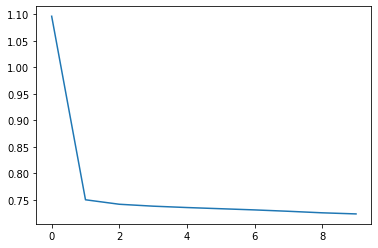

In [ ]:
num_samples=200

costs, accuracy, run_time = backpropagation(W, b, train_set, num_epochs, learning_rate, batch_size, num_samples)
print('Run time: ', run_time)
print('Accuracy: {}%'.format(accuracy*100)) 
plot_cost(costs, num_epochs=10) 

### Backpropagation with vectorizing

In [78]:
def backpropagation_vectorized(W,b, train_set, test_set, num_epochs, learning_rate, batch_size, num_samples):
  
  costs = []

  weight1, weight2, weight3 = W[0], W[1], W[2]
  bias1, bias2, bias3 = b[0], b[1], b[2]

  X, y = shuffle_data(X_train, y_train)
  train_set = list(zip(X,y))
  start = time.time()
  for i in range(num_epochs):
    random.shuffle(train_set)
    batches = [train_set[x:x+batch_size] for x in range(0, 200, batch_size)]
    for batch in batches:

      grad_w1 = np.zeros((16, 1024))
      grad_w2 = np.zeros((16, 16))
      grad_w3 = np.zeros((4, 16))
      grad_b1 = np.zeros((16, 1))
      grad_b2 = np.zeros((16, 1))
      grad_b3 = np.zeros((4, 1))
        
      for image, label in batch:
        image = image.reshape(-1,1)
        label = label.reshape(-1,1)

        z1 = weight1 @ image + bias1
        a1 = sigmoid(z1)
        z2 = weight2 @ a1 + bias2
        a2 = sigmoid(z2)
        z3 = weight3 @ a2 + bias3
        a3 = sigmoid(z3)
            
        grad_w3 += (2 * sigmoid_deriv(z3) * (a3 - label)) @ np.transpose(a2)
        grad_b3 +=  2 * sigmoid_deriv(z3) * (a3- label)
            
        grad_a2 = np.zeros((16, 1))
        grad_a2 += np.transpose(weight3) @ (2 *  sigmoid_deriv(z3) * (a3- label)) 
        grad_w2 += (sigmoid_deriv(z2) * grad_a2) @ np.transpose(a1)   
        grad_b2 +=  sigmoid_deriv(z2) * grad_a2 
                    
        grad_a1 = np.zeros((16, 1))
        grad_a1 += np.transpose(weight2) @ (sigmoid_deriv(z2) * grad_a2)

        grad_w1 += (sigmoid_deriv(z1) * grad_a1) @ np.transpose(image)
        grad_b1 += (sigmoid_deriv(z1) * grad_a1)
        

      weight1 -= learning_rate * (grad_w1 / batch_size)
      weight2 -= learning_rate * (grad_w2 / batch_size)
      weight3 -= learning_rate * (grad_w3 / batch_size)
        
      bias1 -= learning_rate * (grad_b1 / batch_size)
      bias2 -= learning_rate * (grad_b2 / batch_size)
      bias3 -= learning_rate * (grad_b3 / batch_size) 


    cost = 0
    count1 = 0
    count2 = 0

    for train_data in train_set[:num_samples]:
      image = train_data[0].reshape(-1,1)
      label = train_data[1].reshape(-1,1)

      a1 = sigmoid(weight1 @ image + bias1)
      a2 = sigmoid(weight2 @ a1 + bias2)
      a3 = sigmoid(weight3 @ a2 + bias3)
    
      if a3.argmax() == label.argmax():
        count1 += 1

      for j in range(4):
        cost += (a3[j, 0] - label[j,  0]) ** 2
            
    costs.append(cost / num_samples) 

    for test_data in test_set:
      image = test_data[0].reshape(-1,1)
      label = test_data[1].reshape(-1,1)

      a1 = sigmoid(weight1 @ image + bias1)
      a2 = sigmoid(weight2 @ a1 + bias2)
      a3 = sigmoid(weight3 @ a2 + bias3)
    
      if a3.argmax() == label.argmax():
        count2 += 1

  end = time.time()
  train_acc = count1 / num_samples
  test_acc = count2 / len(test_set)
  run_time = end - start

  return costs, train_acc, test_acc, run_time  

Run time:  6.756197214126587
Train Accuracy: 50.0%


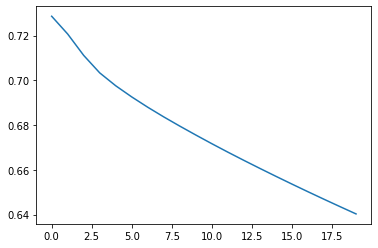

In [60]:
costs, train_acc, test_acc, run_time = backpropagation_vectorized(W, b, train_set, test_set, 20, learning_rate, batch_size, 200)
print('Run time: ', run_time)
print('Train Accuracy: {}%'.format(train_acc*100)) 
plot_cost(costs, num_epochs=20) 

In [42]:
def plot_10_costs(costs):
    rows = len(costs)//5
    fig, axs = plt.subplots(rows, 5, sharex=True, sharey=True, figsize=(15,5))
    
    fig.suptitle('Costs per epoch for each trial')
    for i in range(rows):
        for j in range(5):
            axs[i, j].plot(costs[i*5+j])
            axs[i, j].set_title(f'Trial #{i*5+j+1}')
            axs[i, j].set(xlabel='Epoch', ylabel='Cost')
            axs[i, j].label_outer()
            axs[i, j].set_xticks(np.arange(0, len(costs[i*5+j]), 4))
            axs[i, j].set_xticklabels(np.arange(1, len(costs[i*5+j])+1, 4))
    fig.tight_layout()

Mean accuracy 0.732 %


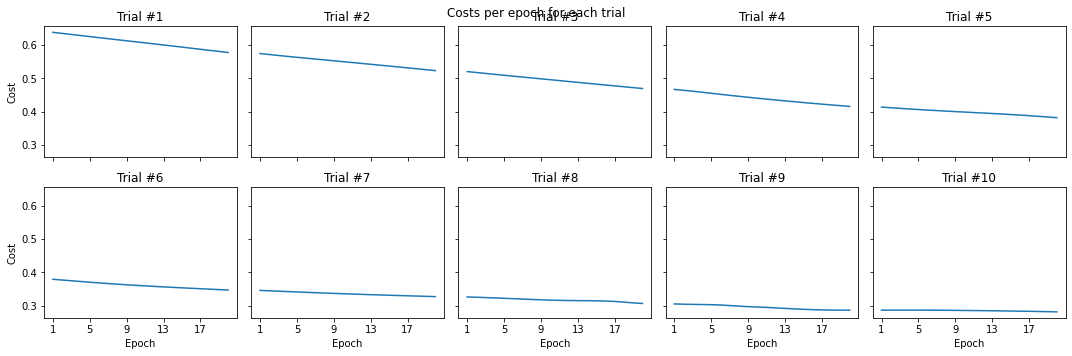

In [61]:
train_accs = []
costs = []

for i in range(10):
  epochs_costs, train_acc, test_acc, run_time = backpropagation_vectorized(W, b, train_set, test_set, 20, learning_rate, batch_size, 200)
  train_accs.append(train_acc)
  costs.append(epochs_costs)

mean_acc = sum(train_accs) / len(train_accs)
print('Mean accuracy {} %'.format(mean_acc))
plot_10_costs(costs)

Run time:  35.83260202407837
Train Accuracy: 35.5125%
Test Accuracy: 36.05%


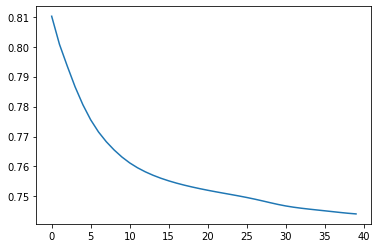

In [65]:
costs, train_acc, test_acc, run_time = backpropagation_vectorized(W, b, train_set, test_set, 40, learning_rate, batch_size, 8000)
print('Run time: ', run_time)
print('Train Accuracy: {}%'.format(train_acc*100)) 
print('Test Accuracy: {}%'.format(test_acc*100)) 
plot_cost(costs, num_epochs=40) 

Mean train accuracy 0.43019999999999997 %
Mean test accuracy 0.4143 %


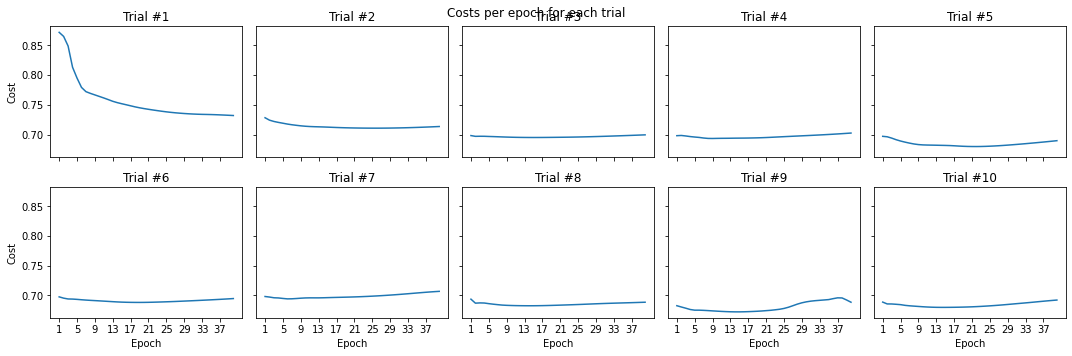

In [82]:
train_accs = []
test_accs = []
costs = []

for i in range(10):
  epochs_costs, train_acc, test_acc, run_time = backpropagation_vectorized(W, b, train_set, test_set, 40, learning_rate, batch_size, 8000)
  train_accs.append(train_acc)
  test_accs.append(test_acc)
  costs.append(epochs_costs)

mean_train_acc = sum(train_accs) / len(train_accs)
mean_test_acc = sum(test_accs) / len(test_accs)
print('Mean train accuracy {} %'.format(mean_train_acc))
print('Mean test accuracy {} %'.format(mean_test_acc))
plot_10_costs(costs)

# Implement model with tensorflow

In [25]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 5s 0us/step


### Simple model

In [26]:
model = keras.Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(10, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                    

In [ ]:
model.compile(optimizer='adam', loss=losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
history = model.fit(train_images, train_labels, batch_size=50, epochs=25, validation_data=(test_images, test_labels))

Epoch 1/25
1000/1000 [==============================] - 35s 24ms/step - loss: 3.8452 - accuracy: 0.3816 - val_loss: 1.4068 - val_accuracy: 0.4832
Epoch 2/25
1000/1000 [==============================] - 24s 24ms/step - loss: 1.3648 - accuracy: 0.5088 - val_loss: 1.2987 - val_accuracy: 0.5331
Epoch 3/25
1000/1000 [==============================] - 24s 24ms/step - loss: 1.2115 - accuracy: 0.5670 - val_loss: 1.1827 - val_accuracy: 0.5739
Epoch 4/25
1000/1000 [==============================] - 25s 25ms/step - loss: 1.0966 - accuracy: 0.6151 - val_loss: 1.0384 - val_accuracy: 0.6359
Epoch 5/25
1000/1000 [==============================] - 24s 24ms/step - loss: 1.0026 - accuracy: 0.6468 - val_loss: 1.0043 - val_accuracy: 0.6457
Epoch 6/25
1000/1000 [==============================] - 24s 24ms/step - loss: 0.9164 - accuracy: 0.6801 - val_loss: 0.9758 - val_accuracy: 0.6635
Epoch 7/25
1000/1000 [==============================] - 24s 24ms/step - loss: 0.8384 - accuracy: 0.7076 - val_loss: 0.9342 -

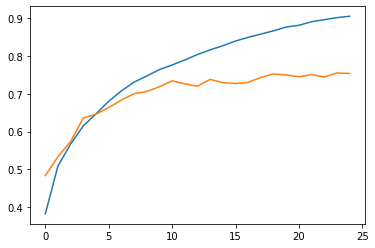

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')

## model with batch normalization layer

In [ ]:
model = keras.Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(10, activation='softmax'))

In [ ]:
model.compile(optimizer='adam', loss=losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                      

In [ ]:
history = model.fit(train_images, train_labels, batch_size=50, epochs=25, validation_data=(test_images, test_labels))

Epoch 1/25
1000/1000 [==============================] - 32s 30ms/step - loss: 1.3490 - accuracy: 0.5126 - val_loss: 1.1599 - val_accuracy: 0.5992
Epoch 2/25
1000/1000 [==============================] - 29s 29ms/step - loss: 0.8564 - accuracy: 0.7002 - val_loss: 0.8921 - val_accuracy: 0.6906
Epoch 3/25
1000/1000 [==============================] - 29s 29ms/step - loss: 0.6608 - accuracy: 0.7711 - val_loss: 0.7645 - val_accuracy: 0.7409
Epoch 4/25
1000/1000 [==============================] - 27s 27ms/step - loss: 0.5338 - accuracy: 0.8163 - val_loss: 0.6747 - val_accuracy: 0.7781
Epoch 5/25
1000/1000 [==============================] - 29s 29ms/step - loss: 0.4425 - accuracy: 0.8474 - val_loss: 0.6865 - val_accuracy: 0.7783
Epoch 6/25
1000/1000 [==============================] - 27s 27ms/step - loss: 0.3585 - accuracy: 0.8766 - val_loss: 0.6300 - val_accuracy: 0.8038
Epoch 7/25
1000/1000 [==============================] - 27s 27ms/step - loss: 0.2920 - accuracy: 0.9001 - val_loss: 0.6823 -

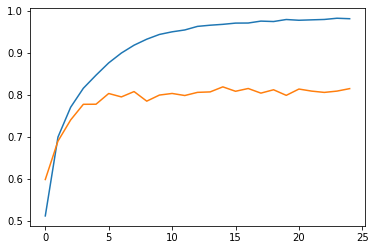

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')

## model with batch normalization and doupout layer and adam optimizer (this is the best model)

In [27]:
model = keras.Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

In [28]:
model.compile(optimizer='adam', loss=losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                      

In [29]:
history = model.fit(train_images, train_labels, batch_size=50, epochs=25, validation_data=(test_images, test_labels))

Epoch 1/25
1000/1000 [==============================] - 51s 40ms/step - loss: 1.8225 - accuracy: 0.3198 - val_loss: 1.3714 - val_accuracy: 0.4797
Epoch 2/25
1000/1000 [==============================] - 39s 39ms/step - loss: 1.3045 - accuracy: 0.5387 - val_loss: 1.2312 - val_accuracy: 0.5709
Epoch 3/25
1000/1000 [==============================] - 39s 39ms/step - loss: 1.0473 - accuracy: 0.6459 - val_loss: 1.0203 - val_accuracy: 0.6485
Epoch 4/25
1000/1000 [==============================] - 40s 40ms/step - loss: 0.8992 - accuracy: 0.7001 - val_loss: 0.7936 - val_accuracy: 0.7317
Epoch 5/25
1000/1000 [==============================] - 39s 39ms/step - loss: 0.7868 - accuracy: 0.7421 - val_loss: 0.7347 - val_accuracy: 0.7586
Epoch 6/25
1000/1000 [==============================] - 39s 39ms/step - loss: 0.7105 - accuracy: 0.7680 - val_loss: 0.6422 - val_accuracy: 0.7874
Epoch 7/25
1000/1000 [==============================] - 39s 39ms/step - loss: 0.6435 - accuracy: 0.7893 - val_loss: 0.6461 -

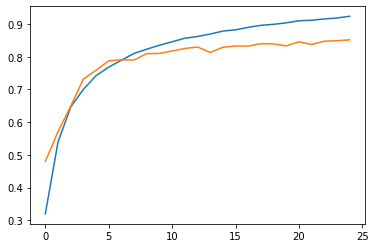

In [32]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')

In [33]:
model.evaluate(test_images, test_labels)

313/313 [==============================] - 4s 10ms/step - loss: 0.5287 - accuracy: 0.8515


[0.5286813974380493, 0.8514999747276306]

In [34]:
preds = model.predict(test_images)
pred_labels = [np.argmax(preds[i]) for i in range(len(test_labels))]
print(classification_report(test_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1000
           1       0.95      0.90      0.93      1000
           2       0.86      0.73      0.79      1000
           3       0.73      0.69      0.71      1000
           4       0.81      0.87      0.84      1000
           5       0.81      0.77      0.79      1000
           6       0.84      0.91      0.87      1000
           7       0.85      0.91      0.88      1000
           8       0.90      0.92      0.91      1000
           9       0.92      0.90      0.91      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [35]:
matrix = confusion_matrix(test_labels, pred_labels, labels=[0, 1])
print('Confusion matrix : \n',matrix)

Confusion matrix : 
 [[903   2]
 [  7 904]]


# model with adagrad optimizer

In [ ]:
model = keras.Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

In [ ]:
model.compile(optimizer=optimizers.Adagrad(), loss=losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
history = model.fit(train_images, train_labels, batch_size=50, epochs=25, validation_data=(test_images, test_labels))

Epoch 1/25
1000/1000 [==============================] - 33s 31ms/step - loss: 2.4248 - accuracy: 0.1550 - val_loss: 2.0458 - val_accuracy: 0.2263
Epoch 2/25
1000/1000 [==============================] - 31s 31ms/step - loss: 2.1703 - accuracy: 0.1972 - val_loss: 1.9499 - val_accuracy: 0.2659
Epoch 3/25
1000/1000 [==============================] - 30s 30ms/step - loss: 2.0829 - accuracy: 0.2204 - val_loss: 1.8781 - val_accuracy: 0.2936
Epoch 4/25
1000/1000 [==============================] - 31s 31ms/step - loss: 2.0248 - accuracy: 0.2391 - val_loss: 1.8180 - val_accuracy: 0.3100
Epoch 5/25
1000/1000 [==============================] - 31s 31ms/step - loss: 1.9776 - accuracy: 0.2513 - val_loss: 1.7649 - val_accuracy: 0.3304
Epoch 6/25
1000/1000 [==============================] - 29s 29ms/step - loss: 1.9332 - accuracy: 0.2664 - val_loss: 1.7207 - val_accuracy: 0.3471
Epoch 7/25
1000/1000 [==============================] - 31s 31ms/step - loss: 1.9053 - accuracy: 0.2735 - val_loss: 1.6850 -

## model with RMSprop optimizer

In [ ]:
model.compile(optimizer=optimizers.RMSprop(), loss=losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
history = model.fit(train_images, train_labels, batch_size=50, epochs=25, validation_data=(test_images, test_labels))

Epoch 1/25
1000/1000 [==============================] - 53s 49ms/step - loss: 1.7248 - accuracy: 0.3711 - val_loss: 1.4341 - val_accuracy: 0.5108
Epoch 2/25
1000/1000 [==============================] - 46s 46ms/step - loss: 1.2110 - accuracy: 0.5818 - val_loss: 1.0371 - val_accuracy: 0.6333
Epoch 3/25
1000/1000 [==============================] - 44s 44ms/step - loss: 1.0099 - accuracy: 0.6630 - val_loss: 0.9262 - val_accuracy: 0.6952
Epoch 4/25
1000/1000 [==============================] - 39s 39ms/step - loss: 0.8829 - accuracy: 0.7099 - val_loss: 0.7756 - val_accuracy: 0.7472
Epoch 5/25
1000/1000 [==============================] - 38s 38ms/step - loss: 0.8023 - accuracy: 0.7414 - val_loss: 0.7996 - val_accuracy: 0.7403
Epoch 6/25
1000/1000 [==============================] - 44s 44ms/step - loss: 0.7433 - accuracy: 0.7637 - val_loss: 0.7239 - val_accuracy: 0.7601
Epoch 7/25
1000/1000 [==============================] - 41s 41ms/step - loss: 0.6888 - accuracy: 0.7813 - val_loss: 0.6496 -

### Plot actual image

Text(0.5, 1.0, 'frog')

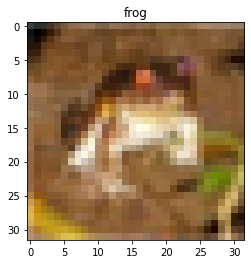

In [83]:
index = 0
img = train_images[index]
plt.imshow(img)
plt.title(class_names[train_labels[index][0]])

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.3
    )
datagen.fit([img])

### Plot artificial images

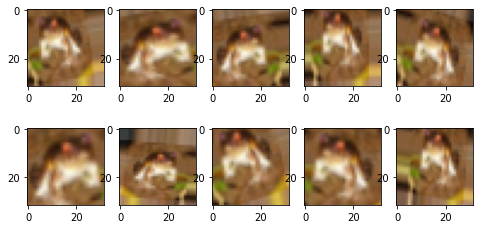

In [ ]:
samples = np.expand_dims(img, 0)
iter = datagen.flow(samples, batch_size=1)

figure, axis = plt.subplots(2, 5, figsize=(8,4))

for i in range(10):
  batch = iter.next()
  image = batch[0].astype('uint8')
  if i < 5:
    axis[0, i].imshow(image)
  else:
    axis[1, i-5].imshow(image)

plt.show()

### Removing 90% of cat and dog images from train set

In [84]:
cat_images = []
cat_labels = []
dog_images = []
dog_labels = []

new_train_images = []
new_train_labels = []

j = 0
k = 0
for i in range(len(train_labels)):
  if class_names[train_labels[i][0]] == 'cat':
    if j < 500:
      new_train_images.append(train_images[i])
      new_train_labels.append(train_labels[i])
      j += 1
    else:
      continue
  elif class_names[train_labels[i][0]] == 'dog':
    if k < 500:
      new_train_images.append(train_images[i])
      new_train_labels.append(train_labels[i])
      k += 1
    else:
      continue
  else:
      new_train_images.append(train_images[i])
      new_train_labels.append(train_labels[i])

In [85]:
new_train_images = np.array(new_train_images)
new_train_labels = np.array(new_train_labels)

In [86]:
model2 = keras.Sequential()
model2.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model2.add(BatchNormalization())
model2.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D((2, 2)))
model2.add(Dropout(0.2))
model2.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model2.add(BatchNormalization())
model2.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D((2, 2)))
model2.add(Dropout(0.2))
model2.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model2.add(BatchNormalization())
model2.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D((2, 2)))
model2.add(Dropout(0.2))
model2.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model2.add(BatchNormalization())
model2.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D((2, 2)))
model2.add(Dropout(0.2))
model2.add(Flatten())
model2.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model2.add(Dropout(0.2))
model2.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model2.add(Dropout(0.2))
model2.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model2.add(Dropout(0.2))
model2.add(Dense(10, activation='softmax'))

In [87]:
model2.compile(optimizer='adam', loss=losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
history = model2.fit(new_train_images, new_train_labels, batch_size=50, epochs=25, validation_data=(test_images, test_labels))

Epoch 1/25
820/820 [==============================] - 34s 39ms/step - loss: 1.6582 - accuracy: 0.3944 - val_loss: 1.8287 - val_accuracy: 0.4302
Epoch 2/25
820/820 [==============================] - 32s 39ms/step - loss: 1.1583 - accuracy: 0.6044 - val_loss: 1.5696 - val_accuracy: 0.5045
Epoch 3/25
820/820 [==============================] - 33s 40ms/step - loss: 0.9304 - accuracy: 0.6937 - val_loss: 1.2944 - val_accuracy: 0.5805
Epoch 4/25
820/820 [==============================] - 33s 40ms/step - loss: 0.7904 - accuracy: 0.7458 - val_loss: 1.1886 - val_accuracy: 0.6254
Epoch 5/25
820/820 [==============================] - 34s 41ms/step - loss: 0.6786 - accuracy: 0.7836 - val_loss: 1.1775 - val_accuracy: 0.6396
Epoch 6/25
820/820 [==============================] - 33s 40ms/step - loss: 0.6074 - accuracy: 0.8062 - val_loss: 1.0300 - val_accuracy: 0.6902
Epoch 7/25
820/820 [==============================] - 32s 39ms/step - loss: 0.5538 - accuracy: 0.8251 - val_loss: 0.9142 - val_accuracy:

In [88]:
model2.evaluate(test_images, test_labels)

313/313 [==============================] - 3s 9ms/step - loss: 0.9867 - accuracy: 0.7598


[0.9866539835929871, 0.7598000168800354]

In [89]:
preds = model2.predict(test_images)
pred_labels = [np.argmax(preds[i]) for i in range(len(test_labels))]
print(classification_report(test_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1000
           1       0.89      0.91      0.90      1000
           2       0.69      0.74      0.71      1000
           3       0.68      0.25      0.36      1000
           4       0.65      0.86      0.74      1000
           5       0.85      0.32      0.46      1000
           6       0.75      0.90      0.82      1000
           7       0.66      0.93      0.77      1000
           8       0.86      0.91      0.88      1000
           9       0.84      0.93      0.88      1000

    accuracy                           0.76     10000
   macro avg       0.77      0.76      0.74     10000
weighted avg       0.77      0.76      0.74     10000



In [90]:
matrix = confusion_matrix(test_labels, pred_labels, labels=[0, 1])
print('Confusion matrix : \n',matrix)

Confusion matrix : 
 [[869  14]
 [  7 910]]


With less data in the training set, accuracy decreased from 85% to 75%